In [22]:
# https://pubs.acs.org/doi/10.1021/acs.jctc.2c01057

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from numpy import linalg as LA

from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from IPython.display import clear_output
from scipy.sparse.linalg import eigs
from scipy import sparse
import math
import time
from joblib import Parallel, delayed
import multiprocessing as multip
from qiskit.quantum_info import Statevector

# Circuit_HEA

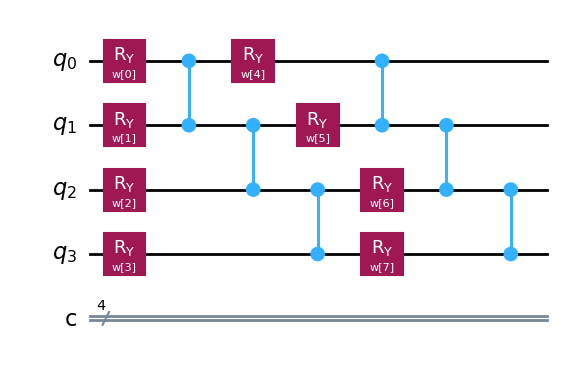

In [23]:
"""circuit construction"""
num_q = 4  # Define the number of qubits
layer = 2  # Define the number of layers in the quantum circuit

# This needs to be determined based on the circuit
num_p = num_q * layer  # Calculate the number of parameters 

weights = ParameterVector("w", num_p)  # Create a vector of parameters (parameters of the quantum circuit)

# Hardware-Efficient Ansatz
def circuit_HEA(weights):
    # ``QuantumCircuit(4, 3) 
    # A QuantumCircuit with 4 qubits and 3 classical bits
    circ = QuantumCircuit(num_q, num_q)  

    for i in range(layer):  # Iterate over each layer
        for j in range(num_q): 
            circ.ry(weights[num_q*i+j], j)  # Apply RY gate to each qubit, the angle is given by elements in the weights array
        for j in range(num_q-1):  
            circ.cz(j, j+1) # Apply CZ gate to each pair of adjacent qubits
    
    return circ  # Return the constructed quantum circuit

qc = circuit_HEA(weights)
# print(qc)
qc.draw("mpl")


## Check if the cost function constructed by this circuit is correct

We check it in two ways:
1. Plot the function graph. It should be a periodic function, like sum of sine and cosine functions.
2. Verify if the function can be accurately interpolated by trigonometric interpolation based on omegas

In [24]:
# Define an observable and mathematically define the true value of the objective function,
# which is the expectation value of the observable.

# Create Hamiltonian H
# H = SparsePauliOp(['ZZII'], 1)
# Hmat = Operator(H)

# Create a random Hamiltonian H
A = np.random.randn(2**num_q, 2**num_q) 
A = A + 1j * np.random.randn(2**num_q, 2**num_q)  # Random complex matrix
Hmat = (A + A.conj().T) / 2  # Hermitian part (A + A†)/2

# labels = ["ZZII", "IXIX"]
# coeffs = [2.+1.j, 3.+2.j]
# coeffs = np.random.uniform(-10, 10, 2)
# H = SparsePauliOp(labels, coeffs)

def expectation_loss_circuit_HEA(weights):
    # Generate the quantum circuit using the provided weights
    circ = circuit_HEA(weights)  

    # Statevector(circ) creates the state of the quantum circuit
    # It computes the final quantum state based on the operations performed by the circuit.
    # The circuit starts from the initial state |0⟩, and then applies the rotation and CZ gates sequentially to obtain the final state.
    # Therefore, psi is the state after applying quantum gates.
    psi = np.array(Statevector(circ))

    Hpsi = Hmat.dot(psi)  # Apply the Hamiltonian to the state: H |psi>
    true_value = np.inner(np.conjugate(psi), Hpsi)  # true expectation value <psi|H|psi>
    
    return true_value.real  # Return the real part


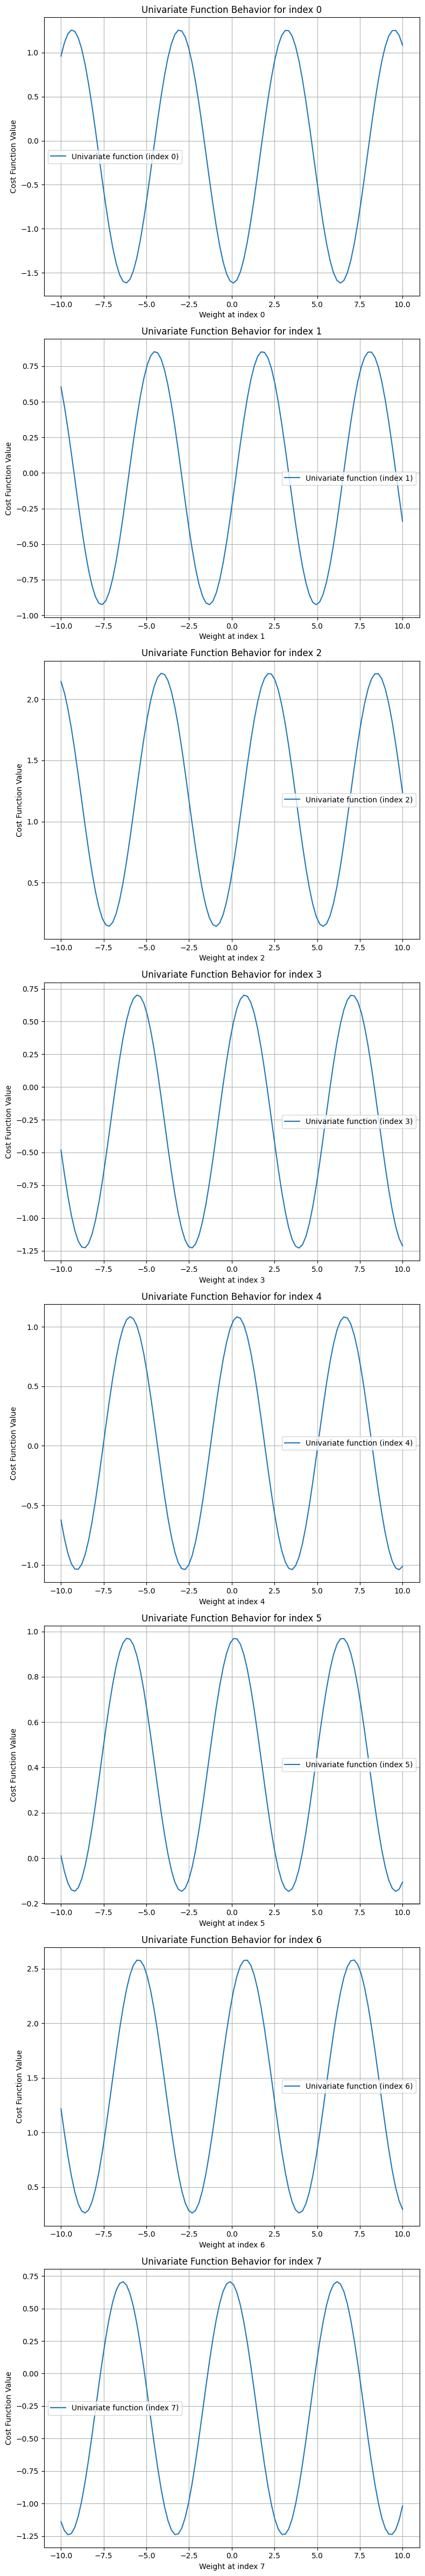

In [25]:
# Way 1. Plot the function graph. 
# It should be a periodic function, like sum of sine and cosine functions.


from check_utils import plot_univariate_function
weights = np.random.normal(0, 4*np.pi**2, num_p) 
# Plot the univariate functions that vary one or more weights at `indices_to_check`.
indices_to_check = range(num_p)
# indices_to_check = [0, 1]
plot_univariate_function(expectation_loss_circuit_HEA, indices_to_check, weights)

In [26]:
# Way 2. Verify if the function can be accurately interpolated by trigonometric interpolation based on omegas

from check_utils import check_is_trigometric  # Assuming check_is_trigometric is defined in check_utils module

# Define random weights
weights = np.random.normal(0, 4 * np.pi**2, num_p)

# Loop over each weight index and check trigonometric interpolation
for j in range(num_p):
    # Circuit_HEA is simple and all Hermitian generators are Y.
    omegas = [1]  # This needs to be determined based on the circuit (i.e., parameters to test interpolation)
    
    print('\n index to check = ', j)
    print('omegas = ', omegas)
    
    opt_interp_flag = False  # Flag to indicate if optimal interpolation should be used
    
    # Call the function to check if the objective function can be interpolated using trigonometric interpolation
    check_is_trigometric(expectation_loss_circuit_HEA, j, omegas, weights, opt_interp_flag)




 index to check =  0
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 0.54972697  0.46185006 -1.26286157]

 index to check =  1
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [0.4546228  0.1494781  0.72230532]

 index to check =  2
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [-0.17944701 -1.47954197 -0.87259399]

 index to check =  3
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [-0.49171836  0.58019058 -0.46508303]

 index to check =  4
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [-0.10502125  1.17939717  0.47426561]

 index to check =  5
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [-0.32604758 -0.4010116  -0.28086305]

 index to check =  6
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [-0.61325868  0.74101813  0.63098963]

 index to check =  7
o

## Check Simulator Results

**How to Measure on a Simulator**

To obtain information about a qubit's state, you can measure it onto a classical bit. 
In Qiskit, measurements are performed in the computational basis, which is the single-qubit Pauli-$Z$ basis. 
Therefore, a measurement yields 0 or 1, depending on the overlap with the Pauli-$Z$ eigenstates $|0\rangle$ and $|1\rangle$:
$$
    |q\rangle \xrightarrow{\text{measure}}\left\{
    \begin{array}{l}
    0 \ (\text{outcome}+1), \ \text{with probability} \ p_0 = |\langle q | 0\rangle|^2, \\
    1 \ (\text{outcome}-1), \ \text{with probability} \ p_1 = |\langle q | 1\rangle|^2.
    \end{array}
    \right.
$$

**Are the Observed Values from the Simulator Normally Distributed?**



In [27]:
simulator = AerSimulator()  # Create the quantum simulator


# Two types of mearsurement: ZZ and Z for our specified observables.
# our specified observables are:
# H = SparsePauliOp(['ZIII'], 1), Z
# H = SparsePauliOp(['IZII'], 1), Z
# H = SparsePauliOp(['ZZII'], 1), ZZ
# H = SparsePauliOp(['ZIZI'], 1), ZZ

# Z mearsurement
def estimate_Z(WEIGHT, Z_index, SHOTS):
    estimate = 0
    qc = circuit_HEA(WEIGHT)

    # The transpile function optimizes the quantum circuit to fit the specified simulator.
    qc = transpile(qc, simulator)

    ind = list(range(num_q))  # Get the quantum bit indices
    rind = ind  
    rind.reverse()  # Reverse the quantum bit indices for classical bit measurement

    # qc.measure(ind, rind) specifies that quantum bits in 'ind' will be measured into classical bits in 'rind',
    # and the measurement results will be stored in reverse order.
    # https://docs.quantum.ibm.com/guides/measure-qubits
    # In Qiskit, measurements are performed in the computational basis, 
    # which is the single-qubit Pauli-Z basis.
    qc.measure(ind, rind)  # Measure the quantum bits into classical bits
    
    # Run the circuit on the simulator and get the results
    # SHOTS represents the total number of experiments, and memory=True keeps the results of each measurement.
    result = simulator.run(qc, shots=SHOTS, memory=True).result()
    
    # Retrieve the memory of the measurement results, which is a list representing the output of each experiment (strings of 0s and 1s).
    # '0' means +1, '1' means -1
    # Either c[i][num_q-1-Z_index] == '0' # '0' means +1
    # Or c[i][num_q-1-Z_2_index] == '1' # '1' means -1
    c = result.get_memory(qc)
        
    for i in range(SHOTS):
        if c[i][num_q-1-Z_index] == '0': # '0' means +1
            estimate += 1
        else: # c[i][num_q-1-Z_index] == '1': '1' means -1
            estimate += -1
    
    estimate = estimate/SHOTS

    return estimate

# ZZ mearsurement
def estimate_ZZ(WEIGHT, Z_1_index, Z_2_index, SHOTS):
    estimate = 0
    qc = circuit_HEA(WEIGHT)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    
    for i in range(SHOTS):
        # If the measurement results for the specified quantum bit indices are the same, add 1; otherwise, subtract 1
        if c[i][num_q-1-Z_1_index] == c[i][num_q-1-Z_2_index]:
            estimate += 1
        else:
            estimate += -1
    
    estimate = estimate / SHOTS  # Calculate the expected value (i.e., ZZ correlation estimate)
    
    return estimate

# ZZZ mearsurement
def estimate_ZZZ(WEIGHT, Z_1_index, Z_2_index, Z_3_index, SHOTS):
    estimate = 0
    qc = circuit_HEA(WEIGHT)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    
    for i in range(SHOTS):
        # If the measurement results for the specified quantum bit indices are the same, add 1; otherwise, subtract 1
        num = [c[i][num_q-1-Z_1_index],c[i][num_q-1-Z_2_index],c[i][num_q-1-Z_3_index]].count('1')
        if num % 2 == 0:
            estimate += 1
        else:
            estimate += -1
    
    estimate = estimate / SHOTS  # Calculate the expected value (i.e., ZZ correlation estimate)
    
    return estimate


def estimate_Zs(WEIGHT, Z_indeces, SHOTS):
    estimate = 0
    qc = circuit_HEA(WEIGHT)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    
    for i in range(SHOTS):
        # If the measurement results for the specified quantum bit indices are the same, add 1; otherwise, subtract 1
        num = [c[i][num_q-1-Z_index] for Z_index in Z_indeces].count('1')
        if num % 2 == 0:
            estimate += 1
        else:
            estimate += -1
    
    estimate = estimate / SHOTS  # Calculate the expected value (i.e., ZZ correlation estimate)
    
    return estimate



In [28]:
shots = 10000
weights = np.random.normal(0, 4*np.pi**2, num_p) 
# 使用正态分布生成随机的权重参数（num_p 是电路参数的数量）。这些权重会用于量子电路中的 RY 门。

In [29]:

# example1: H = ZIII  index = 3 (counting from right to left)

H = SparsePauliOp(['ZIII'], 1)
Hmat = Operator(H)
circ = circuit_HEA(weights)
psi = np.array(Statevector(circ)) 
Hpsi = Hmat.dot(psi) 
true_value = np.inner(np.conjugate(psi), Hpsi) 
# estimated_value = estimate_Z(weights, 3, shots)
estimated_value = estimate_Zs(weights, [3], shots)
print('true_value',true_value) # 比较估计值和真实值
print('error between expectation and measurement result:',np.abs(estimated_value - true_value))


# example2: H = IZII index = 2

H = SparsePauliOp(['IZII'], 1)
Hmat = Operator(H)
circ = circuit_HEA(weights)
psi = np.array(Statevector(circ))
Hpsi = Hmat.dot(psi)
true_value = np.inner(np.conjugate(psi),Hpsi)
# estimated_value = estimate_Z(weights, 2, shots)
estimated_value = estimate_Zs(weights, [2], shots)
print('true_value',true_value)
print('error between expectation and measurement result:',np.abs(estimated_value - true_value))


# example3: H = ZZII index = 3,2

H = SparsePauliOp(['ZZII'], 1)
Hmat = Operator(H)
circ = circuit_HEA(weights)
psi = np.array(Statevector(circ))
Hpsi = Hmat.dot(psi)
true_value = np.inner(np.conjugate(psi),Hpsi)
# estimated_value = estimate_ZZ(weights, 3,2, shots)
estimated_value = estimate_Zs(weights, [3,2], shots)
print('true_value',true_value)
print('error between expectation and measurement result:',np.abs(estimated_value - true_value))
 

# example4: H = ZIZI index = 3,1

H = SparsePauliOp(['ZIZI'], 1)
Hmat = Operator(H)
circ = circuit_HEA(weights)
psi = np.array(Statevector(circ))
Hpsi = Hmat.dot(psi)
true_value = np.inner(np.conjugate(psi),Hpsi)
# estimated_value = estimate_ZZ(weights, 3,1, shots)
estimated_value = estimate_Zs(weights, [3,1], shots)
print('true_value',true_value)
print('error between expectation and measurement result:',np.abs(estimated_value - true_value))


# example5: H = ZZZI index = 3,2,1

H = SparsePauliOp(['ZZZI'], 1)
Hmat = Operator(H)
circ = circuit_HEA(weights)
psi = np.array(Statevector(circ))
Hpsi = Hmat.dot(psi)
true_value = np.inner(np.conjugate(psi),Hpsi)
# estimated_value = estimate_ZZZ(weights, 3,2,1, shots)
estimated_value = estimate_Zs(weights, [3,2,1], shots)
print('true_value',true_value)  
print('error between expectation and measurement result:',np.abs(estimated_value - true_value))

# example6: H = ZIZZ index = 0,3,1

H = SparsePauliOp(['ZIZZ'], 1)
Hmat = Operator(H)
circ = circuit_HEA(weights)
psi = np.array(Statevector(circ))
Hpsi = Hmat.dot(psi)
true_value = np.inner(np.conjugate(psi),Hpsi)
# estimated_value = estimate_ZZZ(weights, 0,1,3, shots)
estimated_value = estimate_Zs(weights, [0,3,1], shots)
print('true_value',true_value)  
print('error between expectation and measurement result:',np.abs(estimated_value - true_value))


# example7: H = ZZZZ index = 0,1,2,3

H = SparsePauliOp(['ZZZZ'], 1)
Hmat = Operator(H)
circ = circuit_HEA(weights)
psi = np.array(Statevector(circ))
Hpsi = Hmat.dot(psi)
true_value = np.inner(np.conjugate(psi),Hpsi)
estimated_value = estimate_Zs(weights, [0,1,2,3], shots)
print('true_value',true_value)  
print('error between expectation and measurement result:',np.abs(estimated_value - true_value))




true_value (0.0008316372396534019+0j)
error between expectation and measurement result: 0.008968362760346597
true_value (-0.781226857005168+0j)
error between expectation and measurement result: 0.0008268570051680468
true_value (-0.008257134690577131+0j)
error between expectation and measurement result: 0.02765713469057713
true_value (0.0010022427844811725+0j)
error between expectation and measurement result: 0.007797757215518828
true_value (0.0027321338372636927+0j)
error between expectation and measurement result: 0.007467866162736308
true_value (-8.311366894017788e-05+0j)
error between expectation and measurement result: 0.008716886331059822
true_value (-0.0012756879165187918+0j)
error between expectation and measurement result: 0.002675687916518792


In [163]:
# 检查模拟器的观测值是否是真实值的正态分布
# 耗时很久

if False:

    H = SparsePauliOp(['ZZZZ'], 1)
    Hmat = Operator(H)
    circ = circuit_HEA(weights)
    psi = np.array(Statevector(circ)) 
    Hpsi = Hmat.dot(psi) 
    true_value = np.inner(np.conjugate(psi), Hpsi) 

    # 收集多次估计结果
    num_trials = 1000
    estimate_results = [estimate_Zs(weights, [0,1,2,3], shots) for _ in range(num_trials)]

    # 绘制结果
    plt.figure(figsize=(10, 6))
    plt.hist(estimate_results, bins=30, density=True, alpha=0.6, color='g', label='Estimation Results')
    plt.axvline(true_value, color='r', linestyle='--', label=f'True Value = {true_value}')
    plt.title('Distribution of estimate_Z outputs')
    plt.xlabel('Estimated Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()


# Circuit_QAOA_XXZ

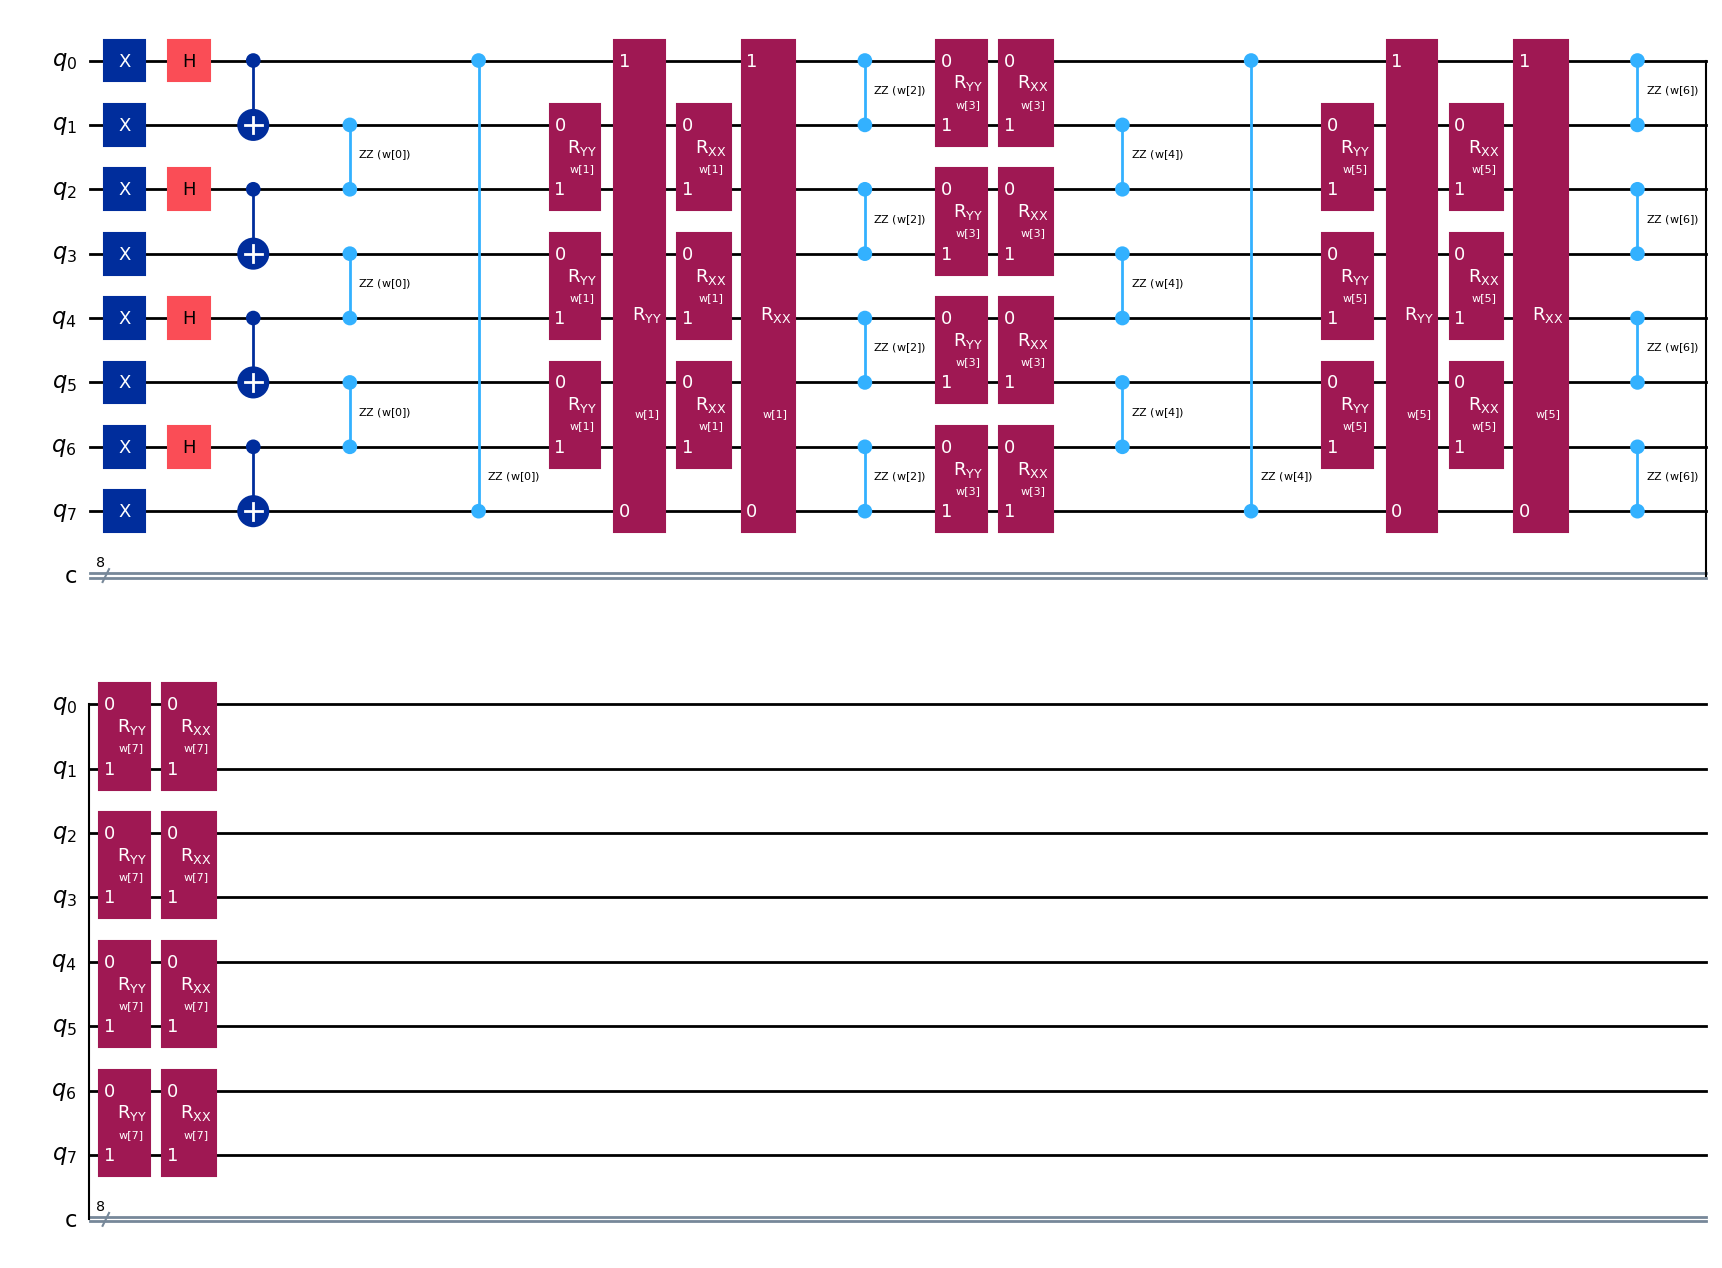

In [164]:
"""circuit construction"""
num_q = 8 # 不能太小, 要大于等于4 否则会报错
layer = 2 # number of layers x2 in QAOA
num_p = layer*4 # number of parameters 注意这里必须是4倍的layer
weights = ParameterVector("w",num_p)

def circuit_QAOA_XXZ(weights):
    circ = QuantumCircuit(num_q, num_q)
    
    # input layer to prepare bell state -\psi
    for j in range(num_q):
        circ.x(j)  # 将所有量子比特都应用了 X 门，这将量子比特从 |0> 初始化到 |1>。
    for j in range(int(num_q / 2)):
        # 然后，对每对相邻的量子比特（2j 和 2j+1）应用了 H 门和 CX（CNOT）门，创建了量子比特的贝尔态。
        circ.h(2 * j)  # 对每对量子比特应用 Hadamard 门，创建叠加态
        circ.cx(2 * j, 2 * j + 1)  # 创建贝尔态：对每对量子比特应用 CNOT 门

    #  QAOA Ansatz（变分层）
    # 每一层包含两个部分：奇数层和偶数层。这是一个大层是layer，里面有2个子层。
    for i in range(layer):
        ## odd layers
        for j in range(int(num_q/2)):
            circ.rzz(weights[4*i], 2*j+1, (2*j+2) % num_q) ## ZZ gates in odd sum
            # weights  [0]
        for j in range(int(num_q/2)):
            circ.ryy(weights[4*i+1], 2*j+1, (2*j+2) % num_q) ## YY gates in odd sum
            # weights  [1]
        for j in range(int(num_q/2)):
            circ.rxx(weights[4*i+1], 2*j+1, (2*j+2) % num_q) ## XX gates in odd sum
            # weights  [1]

        ## even layers
        for j in range(int(num_q/2)):
            circ.rzz(weights[4*i+2], 2*j, 2*j+1) ## ZZ gates in even sum
            # weights  [2]
        for j in range(int(num_q/2)):
            circ.ryy(weights[4*i+3], 2*j, 2*j+1) ## YY gates in even sum
            # weights  [3]
        for j in range(int(num_q/2)):
            circ.rxx(weights[4*i+3], 2*j, 2*j+1) ## XX gates in even sum
            # weights  [3]
      
    return circ 

qc = circuit_QAOA_XXZ(weights)
# print(qc)
qc.draw("mpl")


## Check if the cost function constructed by this circuit is correct

We check it in two ways:
1. Plot the function graph. It should be a periodic function, like sum of sine and cosine functions.
2. Verify if the function can be accurately interpolated by trigonometric interpolation based on omegas

In [165]:
# 设定一个可观测量，然后从数学上定义目标函数的真实值。

# 创建哈密顿量 H
# labels = ["ZZII", "XXII", "YYII", "ZZZZ"]
# coeffs = [2.+1.j, 2.+2.j, 3.+0.j, 3.+0.j]
# coeffs = np.random.uniform(-10, 10, 4)
# H = SparsePauliOp(labels, coeffs)
# Hmat = Operator(H)

# 创建哈密顿量 H
# H = SparsePauliOp(['ZZII'], 1)
# Hmat = Operator(H)

# 创建随机的哈密顿量 H
A = np.random.randn(2**num_q, 2**num_q) 
A = A + 1j * np.random.randn(2**num_q, 2**num_q)  # Random complex matrix
Hmat = (A + A.conj().T) / 2  # Hermitian part (A + A†)/2

def expectation_loss_circuit_QAOA_XXZ(weights):
    circ = circuit_QAOA_XXZ(weights)
    psi = np.array(Statevector(circ)) 
    Hpsi = Hmat.dot(psi)  
    true_value = np.inner(np.conjugate(psi), Hpsi)
    return true_value.real


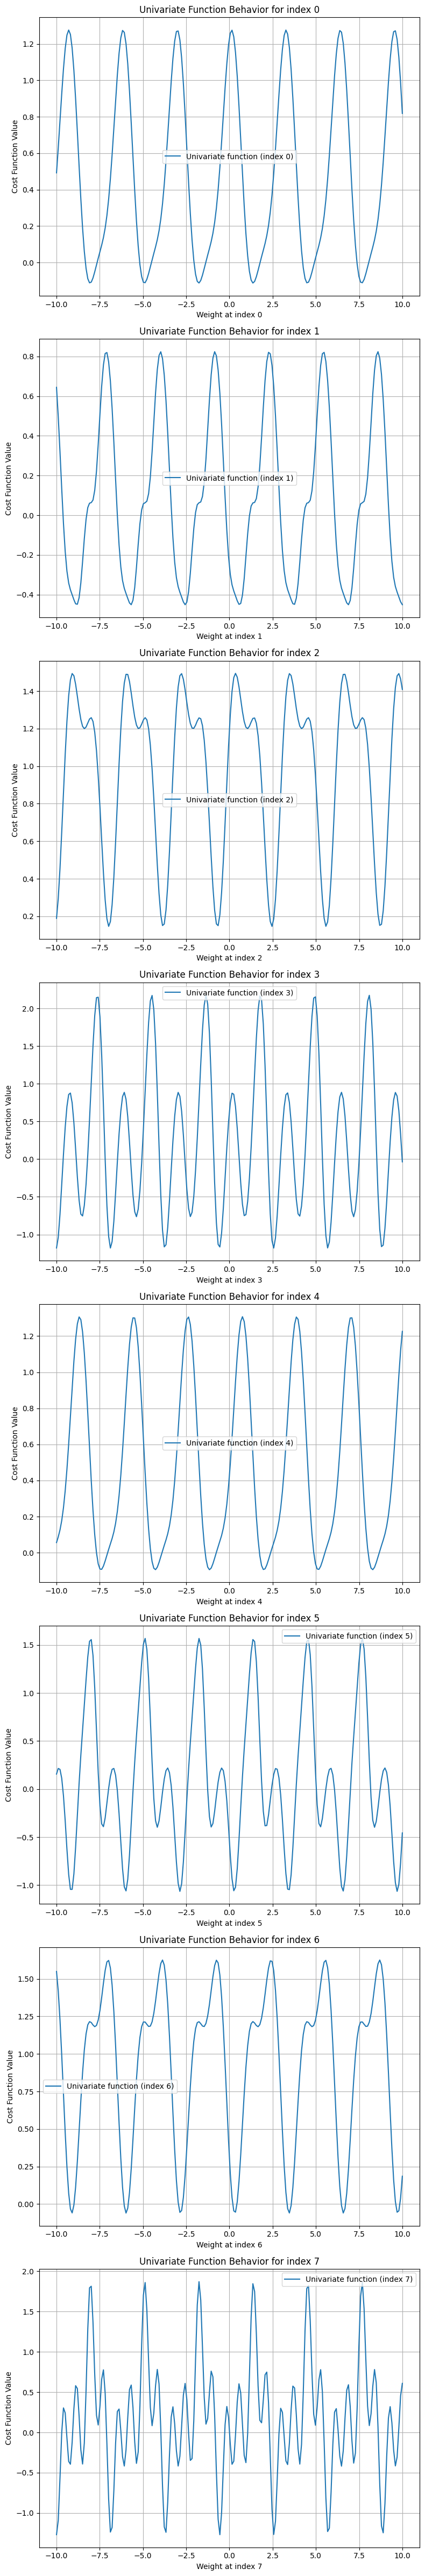

In [166]:
# Plot the univariate functions that vary one or more weights at `indices_to_check`.

from check_utils import plot_univariate_function
weights = np.random.normal(0, 4*np.pi**2, num_p)
plot_univariate_function(expectation_loss_circuit_QAOA_XXZ, range(num_p), weights,num_points=200)

In [167]:
# Check if a cost function behaves like a trigonometric function.

from check_utils import check_is_trigometric
weights = np.random.normal(0, 4*np.pi**2, num_p)

# QAOA_XXZ 中随机Hamiltonian也没有关系
# 函数存在部分系数恒为0的情况. 可以直接跳过对应的插值, 从而节约计算量
# 显然这和QAOA_XXZ的psi (电路结构) 有关.


# odd layers with RZZ gates
# omegas=[2] # for num_q=4,6
# omegas=[2,4] # for num_q=8,10
# omegas=[2,4,6] # for num_q=12,14

# even layers with RYY+RXX gates
# omegas=[2,4] # for num_q=4,6
# omegas=[2,4,6,8] # for num_q=8,10
# omegas=[2,4,6,8,10,12] # for num_q=12,14

for j in range(num_p):
    if j % 2 == 0:  # odd layers with RZZ gates
        # 有多少RZZ gate就有多少个omegas.
        omegas = list(range(1, num_q // 2 + 1))  # General case for odd layers
        if num_q == 4:
            omegas = [2]
        elif num_q == 6:
            omegas = [2]
        elif num_q == 8:
            omegas = [2, 4]
        elif num_q == 10:
            omegas = [2, 4]
        elif num_q == 12:
            omegas = [2, 4, 6]
        elif num_q == 14:
            omegas = [2, 4, 6]

    elif j % 2 == 1:  # even layers with RYY+RXX gates
        # 有多少RYY RXX gate就有多少个omegas.
        omegas = list(range(1, (num_q // 2) * 2 + 1))  # General case for even layers
        if num_q == 4:
            omegas = [2, 4]
        elif num_q == 6:
            omegas = [2, 4]
        elif num_q == 8:
            omegas = [2, 4, 6, 8]
        elif num_q == 10:
            omegas = [2, 4, 6, 8]
        elif num_q == 12:
            omegas = [2, 4, 6, 8, 10, 12]
        elif num_q == 14:
            omegas = [2, 4, 6, 8, 10, 12]

     
    print('\nindex to check = ',j)
    print('omegas = ',omegas)
    # print('\n')
    opt_interp_flag=False
    check_is_trigometric(expectation_loss_circuit_QAOA_XXZ, j, omegas, weights,opt_interp_flag)
    print('='*50)






index to check =  0
omegas =  [2, 4]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 1.65704749  0.58980385 -0.06938578 -0.29499686  0.1716663 ]

index to check =  1
omegas =  [2, 4, 6, 8]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 0.48426418 -0.68002682 -0.43882708 -0.35273423  0.15443967 -0.0509196
  0.01053801  0.00093774 -0.0084297 ]

index to check =  2
omegas =  [2, 4]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 1.25207697  1.58339922  0.2316655   0.25788423 -0.67863319]

index to check =  3
omegas =  [2, 4, 6, 8]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 0.0536539   0.86865061 -0.54299037 -0.94517198 -0.00964974 -0.3442319
 -0.22878128 -0.06262658  0.24443437]

index to check =  4
omegas =  [2, 4]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 1.29921276  0.25036296 -1.39673597 -0.21248285  0.2678187 ]

index to check =  5
omegas =  [2, 4, 6, 8]
Consistent results

In [168]:
simulator = AerSimulator()

def estimate_XX_QAOA(WEIGHT,  X_1_index, X_2_index, SHOTS):
    estimate = 0
    qc = circuit_QAOA_XXZ(WEIGHT)
    # 电路后处理，以应对Z作为可观测量
    for i in range(num_q): ##
        qc.h(i) ##
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1
    for i in range(SHOTS):
        if c[i][num_q-1-X_1_index] == c[i][num_q-1-X_2_index]:
            estimate += 1
        else:
            estimate += -1
    estimate = estimate/SHOTS
    
    return estimate

def estimate_YY_QAOA(WEIGHT,  Y_1_index, Y_2_index, SHOTS):
    estimate = 0
    qc = circuit_QAOA_XXZ(WEIGHT)
    # 电路后处理，以应对Y作为可观测量
    for i in range(num_q):
        qc.sdg(i) ## 
        qc.h(i) ##
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    for i in range(SHOTS):
        if c[i][num_q-1-Y_1_index] == c[i][num_q-1-Y_2_index]:
            estimate += 1
        else:
            estimate += -1
    estimate = estimate/SHOTS
    
    return estimate

def estimate_ZZ_QAOA(WEIGHT,  Z_1_index, Z_2_index, SHOTS):
    estimate = 0
    qc = circuit_QAOA_XXZ(WEIGHT)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    for i in range(SHOTS):
        if c[i][num_q-1-Z_1_index] == c[i][num_q-1-Z_2_index]:
            estimate += 1
        else:
            estimate += -1
    estimate = estimate/SHOTS
    
    return estimate





def estimate_Zs_QAOA(WEIGHT, Z_indeces, SHOTS):
    estimate = 0
    qc = circuit_QAOA_XXZ(WEIGHT)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    
    for i in range(SHOTS):
        # If the measurement results for the specified quantum bit indices are the same, add 1; otherwise, subtract 1
        num = [c[i][num_q-1-Z_index] for Z_index in Z_indeces].count('1')
        if num % 2 == 0:
            estimate += 1
        else:
            estimate += -1
    
    estimate = estimate / SHOTS  # Calculate the expected value (i.e., ZZ correlation estimate)
    
    return estimate




def estimate_Xs_QAOA(WEIGHT, X_indeces, SHOTS):
    estimate = 0
    qc = circuit_QAOA_XXZ(WEIGHT)
    for i in range(num_q): ##
        qc.h(i) ##
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    
    for i in range(SHOTS):
        # If the measurement results for the specified quantum bit indices are the same, add 1; otherwise, subtract 1
        num = [c[i][num_q-1-X_index] for X_index in X_indeces].count('1')
        if num % 2 == 0:
            estimate += 1
        else:
            estimate += -1
    
    estimate = estimate / SHOTS  # Calculate the expected value (i.e., ZZ correlation estimate)
    
    return estimate



def estimate_Ys_QAOA(WEIGHT, Y_indeces, SHOTS):
    estimate = 0
    qc = circuit_QAOA_XXZ(WEIGHT)
    for i in range(num_q):
        qc.sdg(i) ## 
        qc.h(i) ##
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    
    for i in range(SHOTS):
        # If the measurement results for the specified quantum bit indices are the same, add 1; otherwise, subtract 1
        num = [c[i][num_q-1-Y_index] for Y_index in Y_indeces].count('1')
        if num % 2 == 0:
            estimate += 1
        else:
            estimate += -1
    
    estimate = estimate / SHOTS  # Calculate the expected value (i.e., ZZ correlation estimate)
    
    return estimate

In [169]:
shots = 10000
weights = np.random.normal(0,4*np.pi**2,num_p)


In [170]:

# count from right, 3 2 1 0, and X X I I, thus index is 3,2

# example1: H = XXII index = 3,2

H = SparsePauliOp(['XXII'], 1)
Hmat = Operator(H)
circ = circuit_QAOA_XXZ(weights)
psi = np.array(Statevector(circ))
Hpsi = Hmat.dot(psi)
true_value = np.inner(np.conjugate(psi),Hpsi)
# estimated_value = estimate_XX_QAOA(weights, 3,2, shots)
estimated_value = estimate_Xs_QAOA(weights, [3,2], shots)
print('true_value',true_value) # 比较估计值和真实值
print('error between expectation and measurement result:',np.abs(estimated_value - true_value))

# example2: H = IYYI index = 2,1

H = SparsePauliOp(['IYYI'], 1)
Hmat = Operator(H)
circ = circuit_QAOA_XXZ(weights)
psi = np.array(Statevector(circ))
Hpsi = Hmat.dot(psi)
true_value = np.inner(np.conjugate(psi),Hpsi)
# estimated_value = estimate_YY_QAOA(weights, 2,1, shots)
estimated_value = estimate_Ys_QAOA(weights, [1,2], shots)
print('true_value',true_value) # 比较估计值和真实值
print('error between expectation and measurement result:',np.abs(estimated_value - true_value))

# example3: H = ZIIZ index = 3,0

H = SparsePauliOp(['ZZII'], 1)
Hmat = Operator(H)
circ = circuit_QAOA_XXZ(weights)
psi = np.array(Statevector(circ))
Hpsi = Hmat.dot(psi)
true_value = np.inner(np.conjugate(psi),Hpsi)
# estimated_value = estimate_ZZ_QAOA(weights, 3,2, shots)
estimated_value = estimate_Zs_QAOA(weights, [3,2], shots)
print('true_value',true_value) # 比较估计值和真实值
print('error between expectation and measurement result:',np.abs(estimated_value - true_value))


# example3: H = YYYI index = 1,2,3

H = SparsePauliOp(['ZZII'], 1)
Hmat = Operator(H)
circ = circuit_QAOA_XXZ(weights)
psi = np.array(Statevector(circ))
Hpsi = Hmat.dot(psi)
true_value = np.inner(np.conjugate(psi),Hpsi)
estimated_value = estimate_Zs_QAOA(weights, [2,3], shots)
print('true_value',true_value) # 比较估计值和真实值
print('error between expectation and measurement result:',np.abs(estimated_value - true_value))






QiskitError: "Left and right compose dimensions don't match ((2, 2, 2, 2) != (2, 2, 2, 2, 2, 2, 2, 2))"

In [ ]:
# 检查模拟器的观测值是否是真实值的正态分布
# 耗时很久

if False:
    # example1: H = XXII index = 3,2

    H = SparsePauliOp(['XXII'], 1)
    Hmat = Operator(H)
    circ = circuit_QAOA_XXZ(weights)
    psi = np.array(Statevector(circ)) 
    Hpsi = Hmat.dot(psi) 
    true_value = np.inner(np.conjugate(psi), Hpsi) 

    # 收集多次估计结果
    num_trials = 5000
    estimate_results = [estimate_XX_QAOA(weights, 3,2, shots) for _ in range(num_trials)]

    # 绘制结果
    plt.figure(figsize=(10, 6))
    plt.hist(estimate_results, bins=30, density=True, alpha=0.6, color='g', label='Estimation Results')
    plt.axvline(true_value, color='r', linestyle='--', label=f'True Value = {true_value}')
    plt.title('Distribution of estimate_Z outputs')
    plt.xlabel('Estimated Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

In [171]:
def estimate_XYZs_QAOA(WEIGHT, X_indeces, Y_indeces, Z_indeces, SHOTS):
    estimate = 0
    qc = circuit_QAOA_XXZ(WEIGHT)

    All_indeces = X_indeces + Y_indeces + Z_indeces
    for i in X_indeces: ##
        qc.h(i) ##
    for i in Y_indeces: ##
        qc.sdg(i)
        qc.h(i) ##

    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    
    for i in range(SHOTS):
        # If the measurement results for the specified quantum bit indices are the same, add 1; otherwise, subtract 1
        num = [c[i][num_q-1-Z_index] for Z_index in All_indeces].count('1')
        if num % 2 == 0:
            estimate += 1
        else:
            estimate += -1
    
    estimate = estimate / SHOTS  # Calculate the expected value (i.e., ZZ correlation estimate)
    
    return estimate



In [172]:
import random

# List of Pauli operators as strings
pauli_operators = ['I', 'X', 'Y', 'Z']

def random_pauli_word_string(n):
    # Randomly choose a Pauli operator for each qubit
    pauli_word = ''.join(random.choice(pauli_operators) for _ in range(n))
    
    return pauli_word

# Example usage: Generate a random 3-qubit Pauli word
n = 4
random_pauli = random_pauli_word_string(n)

print(f"Random {n}-qubit Pauli word:")
print(random_pauli)


Random 4-qubit Pauli word:
ZZZX


In [173]:
def find_pauli_indices(pauli_word):
    # Initialize empty lists for X, Y, Z indices
    x_indices = []
    y_indices = []
    z_indices = []
    length = len(pauli_word)
    
    # Iterate through the string and track the indices of X, Y, and Z
    for i, char in enumerate(pauli_word):
        if char == 'X':
            x_indices.append(length-1-i)
        elif char == 'Y':
            y_indices.append(length-1-i)
        elif char == 'Z':
            z_indices.append(length-1-i)
    
    return x_indices, y_indices, z_indices

# Example usage
n = 4
random_pauli = random_pauli_word_string(n)
print(f"Random {n}-qubit Pauli word:")
print(random_pauli)
x_indices, y_indices, z_indices = find_pauli_indices(random_pauli)
print(f"Indices of X: {x_indices}")
print(f"Indices of Y: {y_indices}")
print(f"Indices of Z: {z_indices}")


Random 4-qubit Pauli word:
IIII
Indices of X: []
Indices of Y: []
Indices of Z: []


In [191]:
n = num_q
random_pauli = random_pauli_word_string(n)
print(f"Random {n}-qubit Pauli word:")
print(random_pauli)
x_indices, y_indices, z_indices = find_pauli_indices(random_pauli)

H = SparsePauliOp(random_pauli, 1)
Hmat = Operator(H)
circ = circuit_QAOA_XXZ(weights)
psi = np.array(Statevector(circ))
Hpsi = Hmat.dot(psi)
true_value = np.inner(np.conjugate(psi),Hpsi)

estimated_value = estimate_XYZs_QAOA(weights, x_indices, y_indices, z_indices, shots)
print('true_value',true_value) # 比较估计值和真实值
print('error between expectation and measurement result:',np.abs(estimated_value - true_value))

Random 8-qubit Pauli word:
ZIIYYIXY
true_value (0.03488069436569383+8.673617379884035e-19j)
error between expectation and measurement result: 0.005480694365693834


c:\ProgramData\anaconda3\envs\RCD\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


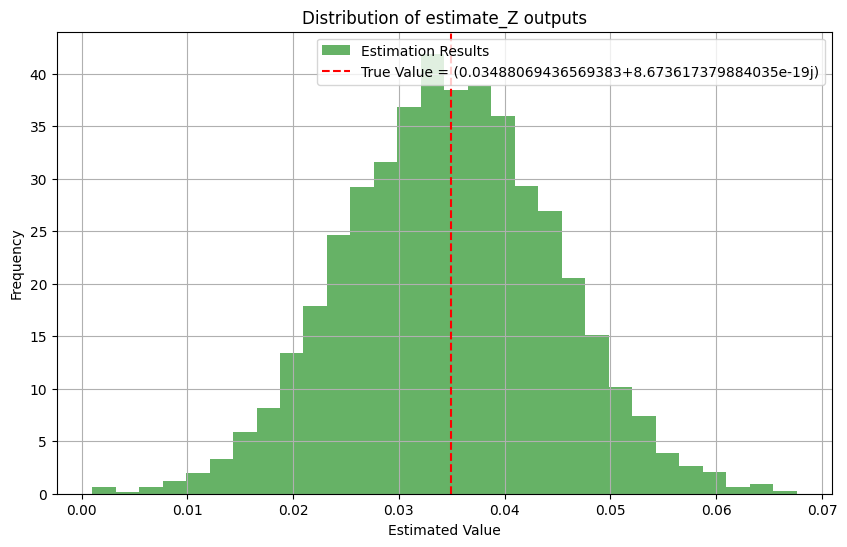

In [ ]:
# 检查模拟器的观测值是否是真实值的正态分布
# 耗时很久

if True:

    # 收集多次估计结果
    num_trials = 5000
    estimate_results = [estimate_XYZs_Q
                        AOA(weights, x_indices, y_indices, z_indices, shots) for _ in range(num_trials)]

    # 绘制结果
    plt.figure(figsize=(10, 6))
    plt.hist(estimate_results, bins=30, density=True, alpha=0.6, color='g', label='Estimation Results')
    plt.axvline(true_value, color='r', linestyle='--', label=f'True Value = {true_value}')
    plt.title('Distribution of estimate_Z outputs')
    plt.xlabel('Estimated Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()